This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
#%run 0_parameters.ipynb

In [2]:
from where import Where
from what import WhatNet
from retina import Retina
import torch
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Training the Where network

In [4]:
from main import init
#args = init(filename='debug')
#args = init(filename='../data/2019-03-19_bis')
#args = init(filename='../data/2020-02-02')
args = init(filename='../data/2019-06-13')

#args = init(filename='../data/2019-03-29')

args.save_model = True
period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
contrast = 0.7
args.contrast = contrast
args.offset_std = 30


In [5]:
nb_saccades = 5
linear = True
if linear:
    figname = '../figures/fig_results_robust_linear_{:.1f}_{}'.format(args.contrast, nb_saccades)
else:
    figname = '../figures/fig_results_robust_{:.1f}_{}'.format(args.contrast, nb_saccades)


In [6]:
figname

'../figures/fig_results_robust_linear_0.7_5'

In [7]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 40,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.5,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.0001,
 'do_adam': True,
 'bn1_bn_momentum': 0.0,
 'bn2_bn_momentum': 0.0,
 'momentum': 0.0,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [8]:
args.epochs = 60

In [9]:
from what import What, WhatTrainer

args.what_offset_max = 25
args.what_offset_std = 15
args.contrast = None

what_suffix = "robust_{}_{}_{}_{}_{}".format(args.sf_0, args.B_sf, args.noise, args.contrast, args.what_offset_std)
what_model_path = "../data/MNIST_cnn_{}.pt".format(what_suffix)
what_model = torch.load(what_model_path)

#what.trainer = WhatTrainer(args,
#                           model=what.model)

#data, target = next(iter(what.trainer.test_loader))



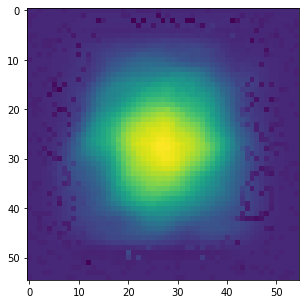

In [10]:
fig = plt.figure(figsize=(5,5))
acc_map_path = "../data/MNIST_accuracy_{}.npy".format(what_suffix)
#print(acc_map_path)
acc_map = np.load(acc_map_path)  
plt.imshow(acc_map)
fig.savefig('../tmp/CNS-accuracy-map.png', bbox_inches='tight', pad_inches=0.1)

In [11]:
#args.train_batch_size = 20
#args.test_batch_size = 20
#retina = Retina(args)
args.contrast = contrast


#plt.show()
#_ = plt.plot(acc_map)
#where = Where(args, what_model=what_model, acc_map=acc_map, robust=True, save_path='../tmp/') #, generate_data=False) #False, save = False)
where = Where(args, what_model=what_model, acc_map=acc_map, save_path='../tmp/') #, generate_data=False) #False, save = False)

#filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-29.pt"
#%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

#where.train(filename_train)

../tmp/where_model__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128.pt
loading model
Dataset : ../tmp/where_train_dataset__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_100.pt
Loading training dataset
Dataset : ../tmp/where_test_dataset__0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_100.pt
Loading testing dataset


In [12]:
what_model

WhatNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
where.model

WhereNet(
  (bn1): Linear(in_features=2880, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=240, bias=True)
)

# accuracy as a function of eccentricity


In [14]:
ecc_max=.8
N_eccentricities = args.N_eccentricity - 1
#eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)

In [15]:
eccentricities

array([40.        , 35.55555556, 31.11111111, 26.66666667, 22.22222222,
       17.77777778, 13.33333333,  8.88888889,  4.44444444])

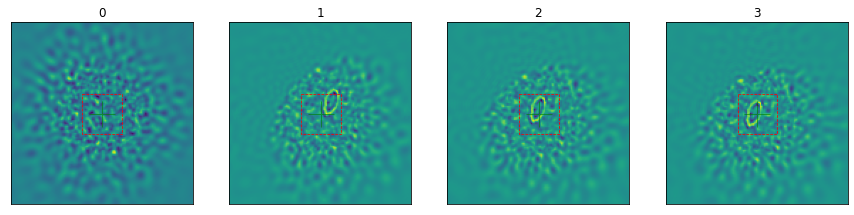

In [47]:
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from where import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, FullfieldRetinaWhiten 
from where import FullfieldRetinaTransform, FullfieldToFloatTensor, Normalize, MNIST
from where import FullfieldCollTransform

eccentricity = 40
batch_size = 1
    
fullfield_transform = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius = eccentricity),
            RetinaBackground(contrast=args.contrast,
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf),
            RetinaMask(N_pic=args.N_pic),
            FullfieldRetinaWhiten(N_pic=args.N_pic),
            FullfieldRetinaTransform(where.retina.retina_transform_vector),
            FullfieldToFloatTensor(),
            #Normalize(fullfield=True)
            # transforms.Normalize((args.mean,), (args.std,))
        ])
fullfield_target_transform=transforms.Compose([
                               CollFill(where.accuracy_map, keep_label = True, N_pic=args.N_pic, baseline=0.1),
                               WhereShift(args, baseline = 0.1, keep_label = True),
                               FullfieldCollTransform(where.retina.colliculus_transform_vector, keep_label = True),
                               FullfieldToFloatTensor(keep_label = True)
                           ])
dataset = MNIST('../data',
                        train=False,
                        download=True,
                        transform=fullfield_transform,
                        target_transform=fullfield_target_transform,
                        )
data_loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True)

fig = plt.figure(figsize = (15, 5))
fig = where.multi_test(4, dataloader=data_loader, batch_size=batch_size, fig=fig)
fig.show()

save_path = '../figures/fig_multi_saccades_example.pdf'
fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

In [41]:
from where import where_suffix
accuracy_mean_linear = {}
accuracy_mean_log = {}
linear=True
for contrast in (0.3, 0.5, 0.7):
    args.contrast = contrast
    suffix = where_suffix(args)
    nb_saccades_max = 5

    if linear:
        file_path_linear = '../data/eccentricity_accuracy_linear_{}_{}.npy'.format(suffix, nb_saccades_max)
        data = np.load(file_path_linear)
        eccentricities_linear = data[0]
        accuracy_mean_linear[contrast] = data[1]

    else:
        file_path_log = '../data/eccentricity_accuracy_{}_{}.npy'.format(suffix, nb_saccades_max)
        data = np.load(file_path_log)
        eccentricities_log = data[0]
        accuracy_mean_log[contrast] = data[1]


In [42]:
colors = ('orange','blue','red','yellow','cyan','purple')
colors = ('orange','blue','blue','blue')

In [44]:

def hist_plot(eccentricities, accuracy_mean, saccade_range, ax_D, colors, linear, 
              title, ylabel=False):
    if not linear:
        width = .3*np.abs(eccentricities)
    else:
        width = 4
        #width = .8*np.abs(np.gradient(eccentricities)[0])
    for num_saccade in saccade_range:
        if num_saccade <2:
            label = str(num_saccade)+' saccade'
        else:
            label = str(num_saccade)+' saccades'
        ax_D.bar(eccentricities, accuracy_mean[num_saccade], width=width, alpha = .5, label = label, color=colors[num_saccade])#yerr=accuracy_std, 
    # TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
    #ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
    
    #ax_D.set_title('Class accuracy', fontsize = 14)
    ax_D.plot([eccentricities.min()-2, eccentricities.max()+2], [0.1]*2, ':', 
              c='k', label = 'Baseline', linewidth=3)
    ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 20)
    ax_D.set_ylim([0,1])
    if ylabel:
        ax_D.set_ylabel('Classification acuracy', fontsize = 20)
    ax_D.tick_params(labelsize=16)
    if not linear:
        ax_D.set_xscale('log')
    ax_D.set_xticks(eccentricities)
    ax_D.set_xticklabels(['%.0f' % d for  d in eccentricities], fontsize = 16)
    
    if not linear:
        ax_D.set_xlim([1.3,30])
    if linear:
        plt.legend(loc='best', fontsize = 14) #,  bbox_to_anchor=(-1.3, 1))
    ax_D.set_title(title, fontsize = 24)

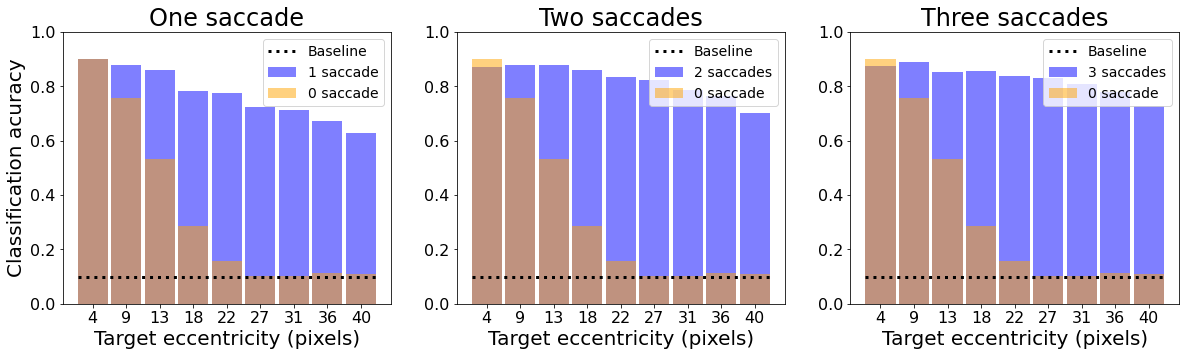

In [45]:
fig = plt.figure(figsize = (20, 5)) #figwidth/1.618))
for num, saccade_range in enumerate(([1, 0], [2, 0], [3, 0])): #([1, 0], [2, 1, 0], [3, 2, 1, 0]):
    ylabel = num==0
    ax_D = fig.add_subplot(1,3,num+1) #(1, 2, 2)
    linear = True
    if max(saccade_range) == 1:
        title = 'One saccade'
    elif max(saccade_range) == 2:
        title = 'Two saccades'
    else:
        title = 'Three saccades'
    hist_plot(eccentricities_linear, accuracy_mean_linear[0.7], saccade_range, 
              ax_D, colors, linear, title, ylabel=ylabel) #, max(saccade_range))#'Full range')
    #plt.show()

save_path = '../figures/fig_results_robust_saccades.pdf'
fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)